https://github.com/eriklindernoren/Keras-GAN/blob/master/bgan/bgan.py

In [0]:
from google.colab import drive
drive.mount('/gdrive')
import os
os.chdir('/gdrive/My Drive/Colab Notebooks/Uni_MNIST')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np
# np.random.seed(0)

Using TensorFlow backend.


In [0]:
class BGAN():
    """Reference: https://wiseodd.github.io/techblog/2017/03/07/boundary-seeking-gan/"""
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.boundary_loss, optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def boundary_loss(self, y_true, y_pred):
        """
        Boundary seeking loss.
        Reference: https://wiseodd.github.io/techblog/2017/03/07/boundary-seeking-gan/
        """
        return 0.5 * K.mean((K.log(y_pred) - K.log(1 - y_pred))**2)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
#         (X_train, _), (_, _) = mnist.load_data()
        X_elastic_all_20=np.load('X_elastic_all_20.npy')
        X_elastic_kannada=X_elastic_all_20[:,0:10,:,:,0]
        X_train=X_elastic_kannada.reshape(60000, 28, 28)
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)
            if(epoch < 1000):
              sample_interval= 50
            else:
              sample_interval=500

            

            # If at save interval => save generated image samples
            if (epoch % sample_interval == 0) :
                # Plot the progress
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)
        


    def sample_images(self, epoch):
        r, c = 8, 8
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images_GAN_elastic_augment/mnist_%d.png" % epoch)
        plt.close()


In [0]:
bgan = BGAN()
bgan.train(epochs=30000, batch_size=32, sample_interval=1000)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.676281, acc.: 48.44%] [G loss: 0.153739]
50 [D loss: 0.018315, acc.: 100.00%] [G loss: 7.746111]
100 [D loss: 0.009219, acc.: 100.00%] [G loss: 11.382764]
150 [D loss: 0.945374, acc.: 56.25%] [G loss: 2.537543]
200 [D loss: 1.605919, acc.: 32.81%] [G loss: 1.431747]
250 [D loss: 0.485414, acc.: 70.31%] [G loss: 3.248221]
300 [D loss: 0.586311, acc.: 64.06%] [G loss: 0.600166]
350 [D loss: 0.524336, acc.: 81.25%] [G loss: 0.509155]
400 [D loss: 0.559684, acc.: 79.69%] [G loss: 0.247542]
450 [D loss: 0.566085, acc.: 75.00%] [G loss: 0.213363]
500 [D loss: 0.526688, acc.: 82.81%] [G loss: 0.327958]
550 [D loss: 0.535505, acc.: 78.12%] [G loss: 0.408033]
600 [D loss: 0.505248, acc.: 79.69%] [G loss: 0.423488]
650 [D loss: 0.456848, acc.: 82.81%] [G loss: 0.513381]
700 [D loss: 0.420076, acc.: 85.94%] [G loss: 0.676422]
750 [D loss: 0.423550, acc.: 84.38%] [G loss: 0.721963]
800 [D loss: 0.435159, acc.: 85.94%] [G loss: 0.956346]
850 [D loss: 0.330263, acc.: 95.31%] [G loss: 1.

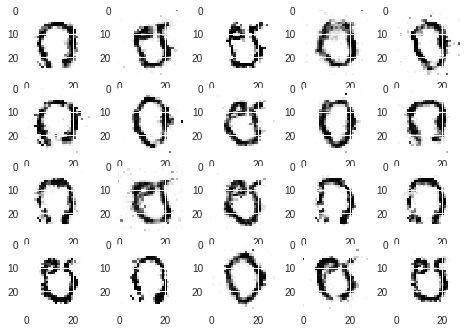

In [0]:
noise = np.random.normal(0, 1, (20, bgan.latent_dim))
gen_imgs = bgan.generator.predict(noise)
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(gen_imgs[i,:,:,0])

In [0]:
import dill
dill.dump_session('bigan_kmnist.pkl')